In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

import statsmodels
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error

# plotting
import matplotlib as mpl
mpl.style.use('ggplot')

In [2]:
statsmodels.__version__

'0.9.0rc1'

In [4]:
train = pd.read_csv('../data/consumption_train.csv',parse_dates=['timestamp'])
test = pd.read_csv('../data/cold_start_test.csv',parse_dates=['timestamp'])
meta = pd.read_csv('../data/meta.csv')

In [5]:
train.head(5)

,Unnamed: 0,series_id,timestamp,consumption,temperature
0,0,103088,2014-12-24 00:00:00,101842.233424,NaN
1,1,103088,2014-12-24 01:00:00,105878.048906,NaN
2,2,103088,2014-12-24 02:00:00,91619.105008,NaN
3,3,103088,2014-12-24 03:00:00,94473.706203,NaN
4,4,103088,2014-12-24 04:00:00,96976.755526,NaN


In [6]:
test.head(5)

,Unnamed: 0,series_id,timestamp,consumption,temperature
0,0,102781,2013-02-27 00:00:00,15295.740389,17.00
1,1,102781,2013-02-27 01:00:00,15163.209562,18.25
2,2,102781,2013-02-27 02:00:00,15022.264079,18.00
3,3,102781,2013-02-27 03:00:00,15370.420458,17.00
4,4,102781,2013-02-27 04:00:00,15303.103213,16.90


In [7]:
meta.head(5)

,series_id,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off
0,100003,x-large,low,False,False,False,False,False,True,True
1,100004,x-large,low,False,False,False,False,False,True,True
2,100006,x-small,low,False,False,False,False,False,True,True
3,100008,x-small,low,False,False,False,False,False,True,True
4,100010,x-small,low,False,False,False,False,False,True,True


In [8]:
for col in meta.columns:
    if col != 'series_id':
        clf = LabelEncoder()
        meta[col] = clf.fit_transform( meta[col])

In [9]:
train = pd.merge(train,meta,how="left")
test = pd.merge(test,meta,how="left")

In [22]:
def mape(y_true,y_pred):
    l = []
    for i in range(len(y_true)):
        if y_true[i] != 0:
            l.append(np.abs(y_true[i]-y_pred[i])/y_true[i]*100)
    return np.mean(l)

In [10]:
from ipywidgets import widgets
from IPython.display import display

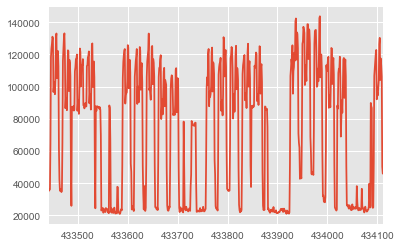

In [11]:
selection1 = widgets.Dropdown(description="series_id")
selection1.options = list(set(train.series_id))
display(selection1)

def on_click_button1(b):
    d = train[train.series_id == selection1.value]
    if len(d) > 0:
        d.consumption.plot()
        plt.show()

button = widgets.Button(description="Make Graph")
display(button)

button.on_click(on_click_button1)

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = train[train.series_id == 102407]
ts_log = ts.consumption
ts_log.index = ts.timestamp

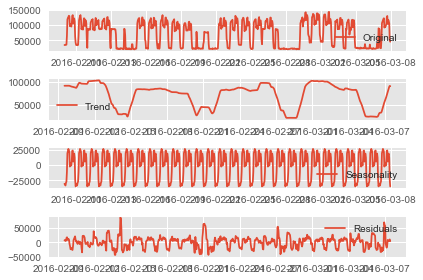

In [25]:
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


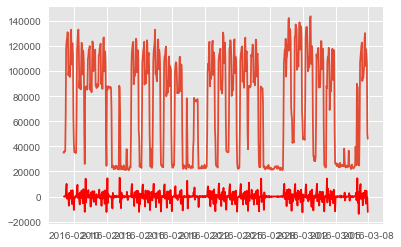

In [26]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(1, 1, 1))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log)
plt.plot(results_AR.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log)**2))
#plt.title('RSS: %.4f'% mean_absolute_error(y_pred=results_AR.fittedvalues,y_true=ts_log))

C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


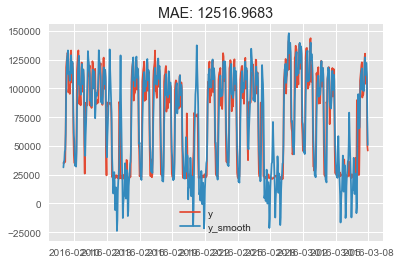

30.2423432997


In [27]:
# our guessed parameters
alpha = 0.4
beta = 0.2
gamma = 0.01

# initialise model
ets_model = ExponentialSmoothing(ts_log, trend='add', seasonal='add', 
seasonal_periods=24)
ets_fit = ets_model.fit(smoothing_level=alpha, smoothing_slope=beta,
smoothing_seasonal=gamma)

# forecast p hours ahead
p_ahead = 24
yh = ets_fit.forecast(p_ahead)

# plot the y, y_smoothed and y_hat ts'
plt.plot(ts_log, label='y')
plt.plot(ets_fit.fittedvalues, label='y_smooth')
#plt.plot(range(days * m, days * m + p_ahead),yh, label='y_hat')

plt.title('MAE: %.4f'% mean_absolute_error(y_pred=ets_fit.fittedvalues,y_true=ts_log))

plt.legend()
plt.show()

print (mape(y_pred=ets_fit.fittedvalues,y_true=ts_log))

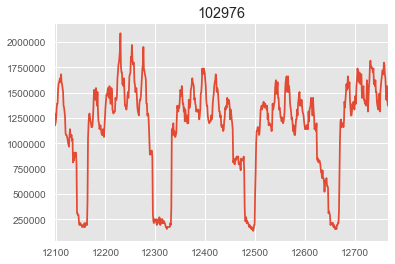

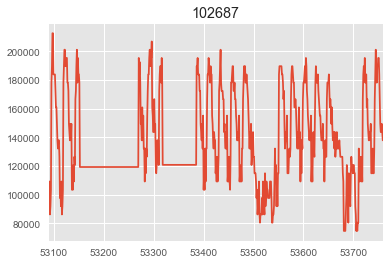

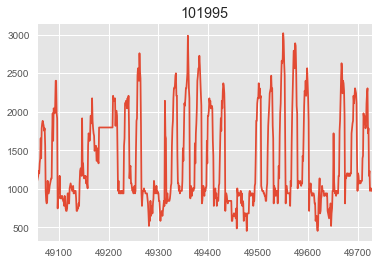

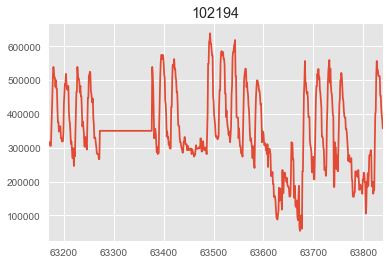

In [21]:
selection2 = widgets.Dropdown(description="surface")
selection2.options = list(set(train.surface))
display(selection2)

def on_click_button2(b):
    d = train[train.surface == selection2.value]
    if len(d) > 0:
        sid = d.series_id.iloc[0]
        plt.title(sid)
        d[d.series_id == sid].consumption.plot()
        plt.show()

button = widgets.Button(description="Make Graph")
display(button)

button.on_click(on_click_button2)

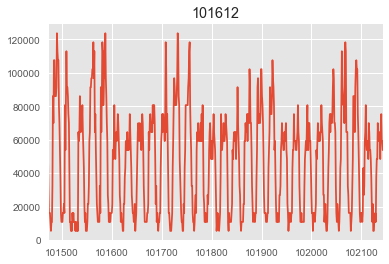

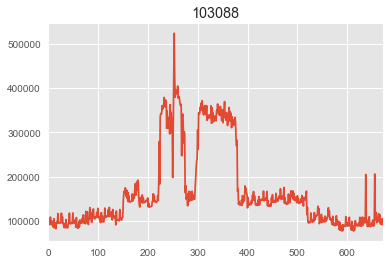

In [22]:
selection3 = widgets.Dropdown(description="base_temperature")
selection3.options = list(set(train.base_temperature))
display(selection3)

def on_click_button3(b):
    d = train[train.base_temperature == selection3.value]
    if len(d) > 0:
        sid = d.series_id.iloc[0]    
        plt.title(sid)
        d[d.series_id == sid].consumption.plot()
        plt.show()

button = widgets.Button(description="Make Graph")
display(button)

button.on_click(on_click_button3)

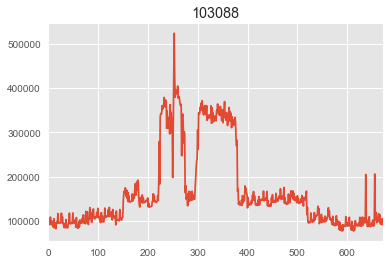

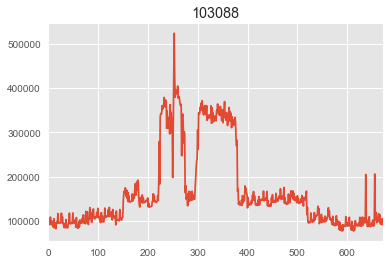

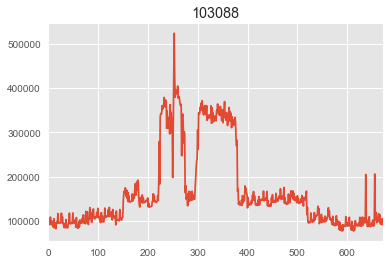

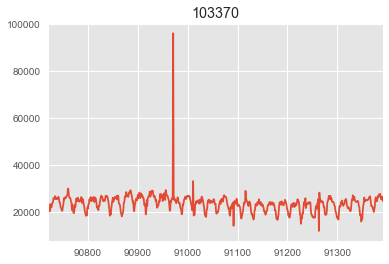

In [26]:
selection4 = widgets.Dropdown(description="offday")
selection4.options = ["monday_is_day_off","tuesday_is_day_off","wednesday_is_day_off","thursday_is_day_off","friday_is_day_off","saturday_is_day_off","sunday_is_day_off"]
display(selection4)

selection5 = widgets.Dropdown(description="True/False")
selection5.options = [1,0]
display(selection5)

def on_click_button4(b):
    d = train[train[selection4.value] == selection5.value]
    if len(d) > 0:
        sid = d.series_id.iloc[0]    
        plt.title(sid)
        d[d.series_id == sid].consumption.plot()
        plt.show()

button = widgets.Button(description="Make Graph")
display(button)

button.on_click(on_click_button4)

In [121]:
def forecast_daily_test(series_id):
    ts = test[test.series_id == series_id]
    ts_log = ts.consumption
    ts_log.index = ts.timestamp

    '''
    decomposition = seasonal_decompose(ts_log)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    '''
    # our guessed parameters
    alpha = 0.4
    beta = 0.2
    gamma = 0.01

    # initialise model
    #ets_model = ExponentialSmoothing(ts_log,seasonal='add',seasonal_periods=24)
    #ets_fit = ets_model.fit(smoothing_level=alpha, smoothing_slope=beta,
#smoothing_seasonal=gamma)
    #ets_model = ExponentialSmoothing(ts_log)
    #ets_fit = ets_model.fit()
    ets_model = ExponentialSmoothing(ts_log,seasonal='add',seasonal_periods=24)
    ets_fit = ets_model.fit(smoothing_level=alpha, smoothing_slope=beta,smoothing_seasonal=gamma)

    # forecast p hours ahead
    p_ahead = 24
    yh = ets_fit.forecast(p_ahead)

    # plot the y, y_smoothed and y_hat ts'
    #plt.plot(ts_log, label='y')
    #plt.plot(ets_fit.fittedvalues, label='y_smooth')
    #plt.plot(yh,label='forecast',color='black')

    #plt.title('MAE: %.4f'% mean_absolute_error(y_pred=ets_fit.fittedvalues,y_true=ts_log))

    #plt.legend()
    #plt.show()

    print (mape(y_pred=ets_fit.fittedvalues,y_true=ts_log))

        
    return yh.values

In [123]:
best_submission = pd.read_csv('../data/submissions/submmission6.csv')
num_test_series = best_submission.series_id.nunique()

In [124]:
for ser_id, pred_df in tqdm(best_submission.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
    if pred_df.prediction_window.iloc[0] == 'hourly':
        ser_id_mask = best_submission.series_id == ser_id
        yhat = list(forecast_daily_test(ser_id))
        best_submission.loc[ser_id_mask, 'consumption'] = yhat

Forecasting from Cold Start Data:   0%|                | 0/625 [00:00<?, ?it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


169.653357134


Forecasting from Cold Start Data:   0%|        | 2/625 [00:00<01:43,  6.01it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


19.6050436051


Forecasting from Cold Start Data:   0%|        | 3/625 [00:00<03:16,  3.16it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


68.5687812305


Forecasting from Cold Start Data:   1%|        | 6/625 [00:01<02:10,  4.74it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.31903008594


Forecasting from Cold Start Data:   1%|        | 7/625 [00:01<02:42,  3.81it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


5.67586681546


Forecasting from Cold Start Data:   4%|▎      | 25/625 [00:02<00:51, 11.72it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


5.34421780858


Forecasting from Cold Start Data:   5%|▎      | 30/625 [00:02<00:56, 10.46it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


111.203426753


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


11.1170310808


Forecasting from Cold Start Data:   5%|▎      | 32/625 [00:03<01:05,  9.12it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


41.8877536467


Forecasting from Cold Start Data:   6%|▍      | 39/625 [00:03<00:56, 10.43it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:734: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + (k) * 2
C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:736: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + (k) * np.log(self.nobs)


0.0


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


13.293743829


Forecasting from Cold Start Data:   7%|▍      | 41/625 [00:04<01:01,  9.49it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


44.9711540707


Forecasting from Cold Start Data:   7%|▍      | 43/625 [00:05<01:08,  8.49it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.30617701166


Forecasting from Cold Start Data:   7%|▌      | 45/625 [00:05<01:15,  7.71it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


859.345299451


Forecasting from Cold Start Data:   7%|▌      | 46/625 [00:06<01:21,  7.13it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


1.14194128947


Forecasting from Cold Start Data:   8%|▌      | 49/625 [00:06<01:19,  7.26it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


30.4970283453


Forecasting from Cold Start Data:   8%|▌      | 52/625 [00:07<01:18,  7.34it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


60.6815041245


Forecasting from Cold Start Data:   9%|▌      | 55/625 [00:07<01:19,  7.19it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


17.5222254261


Forecasting from Cold Start Data:  10%|▋      | 60/625 [00:07<01:13,  7.70it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


12.1815849293


Forecasting from Cold Start Data:  11%|▊      | 67/625 [00:08<01:12,  7.70it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


179.69635541


Forecasting from Cold Start Data:  12%|▊      | 73/625 [00:10<01:20,  6.89it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


13.0015124676


Forecasting from Cold Start Data:  12%|▊      | 77/625 [00:11<01:19,  6.92it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.84870698021


Forecasting from Cold Start Data:  13%|▉      | 79/625 [00:11<01:19,  6.90it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


107.923429245


Forecasting from Cold Start Data:  13%|▉      | 82/625 [00:11<01:17,  7.01it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


11.0030456551


Forecasting from Cold Start Data:  14%|▉      | 85/625 [00:12<01:17,  7.01it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


3.79803772838e-15


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


67.9263765748


Forecasting from Cold Start Data:  14%|▉      | 87/625 [00:12<01:15,  7.09it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


15.0896785054


Forecasting from Cold Start Data:  14%|▉      | 89/625 [00:13<01:18,  6.81it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


20.1009114749


Forecasting from Cold Start Data:  15%|█      | 91/625 [00:14<01:25,  6.28it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.28471517535


Forecasting from Cold Start Data:  16%|█      | 97/625 [00:14<01:20,  6.56it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


7.16121944285


Forecasting from Cold Start Data:  16%|▉     | 100/625 [00:15<01:19,  6.61it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


11.7614931017


Forecasting from Cold Start Data:  16%|▉     | 101/625 [00:15<01:20,  6.53it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


3.53914645963


Forecasting from Cold Start Data:  16%|▉     | 102/625 [00:15<01:21,  6.45it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


13.5044861823


Forecasting from Cold Start Data:  17%|█     | 108/625 [00:16<01:17,  6.71it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


20.2354616076


Forecasting from Cold Start Data:  18%|█     | 112/625 [00:16<01:14,  6.85it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


10.8350979745


Forecasting from Cold Start Data:  18%|█     | 114/625 [00:16<01:14,  6.86it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


18.7491011721


Forecasting from Cold Start Data:  19%|█     | 116/625 [00:17<01:15,  6.73it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


12.3188280763


Forecasting from Cold Start Data:  19%|█▏    | 118/625 [00:17<01:15,  6.70it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


12.7232515678


Forecasting from Cold Start Data:  19%|█▏    | 120/625 [00:17<01:15,  6.67it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.22564249304


Forecasting from Cold Start Data:  19%|█▏    | 121/625 [00:18<01:18,  6.41it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


19.4190003091


Forecasting from Cold Start Data:  20%|█▏    | 124/625 [00:20<01:21,  6.14it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.0


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


11.8867789647


Forecasting from Cold Start Data:  20%|█▏    | 126/625 [00:20<01:21,  6.16it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


28.9696296156


Forecasting from Cold Start Data:  21%|█▏    | 129/625 [00:21<01:22,  6.04it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


6.82183997709


Forecasting from Cold Start Data:  21%|█▎    | 131/625 [00:23<01:27,  5.62it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


55.5592494526


Forecasting from Cold Start Data:  22%|█▎    | 135/625 [00:23<01:25,  5.73it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


118.372147294


Forecasting from Cold Start Data:  22%|█▎    | 137/625 [00:23<01:24,  5.77it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.7902062503


Forecasting from Cold Start Data:  22%|█▎    | 138/625 [00:24<01:26,  5.66it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.0


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


7.97015900825


Forecasting from Cold Start Data:  22%|█▎    | 140/625 [00:24<01:25,  5.67it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.71434453552


Forecasting from Cold Start Data:  23%|█▎    | 141/625 [00:25<01:27,  5.56it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.1569805051


Forecasting from Cold Start Data:  23%|█▍    | 144/625 [00:26<01:28,  5.44it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


83.4086723322


Forecasting from Cold Start Data:  23%|█▍    | 145/625 [00:27<01:30,  5.28it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.28168270726


Forecasting from Cold Start Data:  23%|█▍    | 146/625 [00:28<01:33,  5.14it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


7.69305119557


Forecasting from Cold Start Data:  24%|█▍    | 149/625 [00:28<01:31,  5.21it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.62861484669


Forecasting from Cold Start Data:  24%|█▍    | 150/625 [00:29<01:32,  5.13it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.38154313187


Forecasting from Cold Start Data:  24%|█▍    | 151/625 [00:29<01:32,  5.13it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


16.4195191163


Forecasting from Cold Start Data:  25%|█▍    | 154/625 [00:30<01:33,  5.03it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


10.2371080425


Forecasting from Cold Start Data:  25%|█▍    | 155/625 [00:30<01:33,  5.02it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.00724322154


Forecasting from Cold Start Data:  25%|█▌    | 157/625 [00:31<01:34,  4.94it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


3.70883929204


Forecasting from Cold Start Data:  25%|█▌    | 158/625 [00:31<01:34,  4.95it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


20.964632574


Forecasting from Cold Start Data:  26%|█▌    | 161/625 [00:32<01:33,  4.97it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


10.6991842184


Forecasting from Cold Start Data:  27%|█▌    | 166/625 [00:32<01:30,  5.06it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


1.7161348835


Forecasting from Cold Start Data:  27%|█▌    | 167/625 [00:34<01:33,  4.91it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


105.052826086


Forecasting from Cold Start Data:  27%|█▌    | 168/625 [00:34<01:32,  4.92it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


16.5703026349


Forecasting from Cold Start Data:  27%|█▌    | 169/625 [00:34<01:32,  4.92it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


69.1505055253


Forecasting from Cold Start Data:  28%|█▋    | 172/625 [00:34<01:31,  4.95it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


48.5608936531


Forecasting from Cold Start Data:  28%|█▋    | 173/625 [00:35<01:32,  4.89it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


1.6815925765


Forecasting from Cold Start Data:  28%|█▋    | 178/625 [00:39<01:40,  4.46it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


20.9920717595


Forecasting from Cold Start Data:  29%|█▋    | 179/625 [00:41<01:44,  4.28it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


67.4925256187


Forecasting from Cold Start Data:  29%|█▋    | 180/625 [00:42<01:45,  4.24it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.86779910907


Forecasting from Cold Start Data:  29%|█▋    | 182/625 [00:42<01:44,  4.25it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


10.0207717653


Forecasting from Cold Start Data:  29%|█▊    | 183/625 [00:43<01:44,  4.24it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


23.3572088153


Forecasting from Cold Start Data:  29%|█▊    | 184/625 [00:43<01:44,  4.23it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


23.7231524819


Forecasting from Cold Start Data:  30%|█▊    | 185/625 [00:44<01:45,  4.17it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


16.8382421084


Forecasting from Cold Start Data:  30%|█▊    | 190/625 [00:44<01:42,  4.25it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


98.9616233757


Forecasting from Cold Start Data:  31%|█▊    | 193/625 [00:45<01:40,  4.28it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


15.2547431756


Forecasting from Cold Start Data:  32%|█▉    | 197/625 [00:45<01:39,  4.32it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


247.134271785


Forecasting from Cold Start Data:  32%|█▉    | 199/625 [00:46<01:38,  4.32it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


1.88956075762


Forecasting from Cold Start Data:  32%|█▉    | 201/625 [00:46<01:37,  4.34it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


11.3587491613


Forecasting from Cold Start Data:  32%|█▉    | 203/625 [00:46<01:37,  4.35it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.0


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.24504496013


Forecasting from Cold Start Data:  34%|██    | 214/625 [00:46<01:30,  4.56it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


55.6603954693


Forecasting from Cold Start Data:  35%|██    | 216/625 [00:47<01:29,  4.58it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


126.752463245


Forecasting from Cold Start Data:  35%|██    | 218/625 [00:47<01:28,  4.60it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.31098830579e-15


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.79254929578


Forecasting from Cold Start Data:  35%|██    | 220/625 [00:49<01:30,  4.48it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


31.0423573301


Forecasting from Cold Start Data:  36%|██▏   | 222/625 [00:50<01:30,  4.43it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


1.65128895795


Forecasting from Cold Start Data:  37%|██▏   | 231/625 [00:50<01:26,  4.56it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


31.5605135137


Forecasting from Cold Start Data:  37%|██▏   | 233/625 [00:50<01:25,  4.58it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


24.1021947056


Forecasting from Cold Start Data:  38%|██▎   | 236/625 [00:51<01:24,  4.62it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.02255503345


Forecasting from Cold Start Data:  38%|██▎   | 238/625 [00:51<01:23,  4.62it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


51.6144022546


Forecasting from Cold Start Data:  39%|██▎   | 242/625 [00:51<01:22,  4.66it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.56707448011


Forecasting from Cold Start Data:  39%|██▎   | 244/625 [00:52<01:21,  4.68it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.8364258891e-15


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.41946750823


Forecasting from Cold Start Data:  40%|██▍   | 253/625 [00:52<01:16,  4.83it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


725.904621551


Forecasting from Cold Start Data:  41%|██▍   | 256/625 [00:52<01:15,  4.86it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.0


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.90058980817


Forecasting from Cold Start Data:  41%|██▍   | 259/625 [00:52<01:14,  4.89it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


866.477699708


Forecasting from Cold Start Data:  42%|██▌   | 261/625 [00:53<01:14,  4.87it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


47.207457102


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.0


Forecasting from Cold Start Data:  42%|██▌   | 263/625 [00:54<01:14,  4.86it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.0


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


3.42465646724


Forecasting from Cold Start Data:  43%|██▌   | 268/625 [00:54<01:13,  4.89it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


15.5562269965


Forecasting from Cold Start Data:  44%|██▌   | 272/625 [00:54<01:11,  4.95it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.47961976784


Forecasting from Cold Start Data:  44%|██▋   | 277/625 [00:55<01:09,  5.02it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.31953731693


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


1214.80119661


Forecasting from Cold Start Data:  45%|██▋   | 279/625 [00:55<01:09,  5.00it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


7.82101264178


Forecasting from Cold Start Data:  46%|██▋   | 286/625 [00:56<01:06,  5.08it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.81631439928


Forecasting from Cold Start Data:  47%|██▊   | 291/625 [00:57<01:06,  5.04it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


85.2652145822


Forecasting from Cold Start Data:  49%|██▉   | 304/625 [00:58<01:01,  5.19it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.78561187199


Forecasting from Cold Start Data:  50%|███   | 313/625 [00:59<00:59,  5.24it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


108.415945594


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.96635729864


Forecasting from Cold Start Data:  50%|███   | 315/625 [01:00<01:00,  5.16it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


1.00752382443e-15


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.22407624329


Forecasting from Cold Start Data:  51%|███   | 320/625 [01:01<00:58,  5.21it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


43.7629563824


Forecasting from Cold Start Data:  51%|███   | 321/625 [01:02<00:59,  5.15it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


65.6712601961


Forecasting from Cold Start Data:  52%|███   | 323/625 [01:03<00:58,  5.12it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


10.0697413284


Forecasting from Cold Start Data:  52%|███   | 325/625 [01:03<00:58,  5.10it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.0


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


42.3285486038


Forecasting from Cold Start Data:  53%|███▏  | 329/625 [01:04<00:57,  5.11it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.13854210075


Forecasting from Cold Start Data:  53%|███▏  | 332/625 [01:04<00:57,  5.13it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


17.4327283651


Forecasting from Cold Start Data:  54%|███▏  | 337/625 [01:05<00:55,  5.18it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.25774070487


Forecasting from Cold Start Data:  54%|███▏  | 338/625 [01:05<00:55,  5.18it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


7.65405143971


Forecasting from Cold Start Data:  54%|███▎  | 340/625 [01:05<00:54,  5.18it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


363.778960397


Forecasting from Cold Start Data:  55%|███▎  | 341/625 [01:06<00:55,  5.15it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


16.6316269325


Forecasting from Cold Start Data:  55%|███▎  | 342/625 [01:06<00:55,  5.14it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


16.0892845163


Forecasting from Cold Start Data:  55%|███▎  | 344/625 [01:07<00:54,  5.12it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


20.5903470766


Forecasting from Cold Start Data:  55%|███▎  | 345/625 [01:07<00:55,  5.07it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


61.7132161176


Forecasting from Cold Start Data:  56%|███▎  | 347/625 [01:08<00:55,  5.03it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.29051255524


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.24627796828


Forecasting from Cold Start Data:  56%|███▎  | 351/625 [01:09<00:54,  5.07it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


16.5565190907


Forecasting from Cold Start Data:  56%|███▍  | 352/625 [01:09<00:53,  5.07it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


18.5853822523


Forecasting from Cold Start Data:  57%|███▍  | 354/625 [01:09<00:53,  5.08it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


2.50289647048


Forecasting from Cold Start Data:  57%|███▍  | 355/625 [01:10<00:53,  5.03it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


7.77193515731


Forecasting from Cold Start Data:  57%|███▍  | 356/625 [01:10<00:53,  5.03it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


23.5448693598


Forecasting from Cold Start Data:  57%|███▍  | 357/625 [01:11<00:53,  5.02it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


15.2234302974


Forecasting from Cold Start Data:  57%|███▍  | 358/625 [01:11<00:53,  4.99it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


3.78826512994


Forecasting from Cold Start Data:  58%|███▍  | 360/625 [01:12<00:53,  5.00it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.13944775417


Forecasting from Cold Start Data:  58%|███▍  | 362/625 [01:12<00:52,  5.01it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.17667373567


Forecasting from Cold Start Data:  59%|███▌  | 367/625 [01:12<00:50,  5.06it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


88.6126068408


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.0


Forecasting from Cold Start Data:  59%|███▌  | 369/625 [01:12<00:50,  5.06it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


6.06836704961


Forecasting from Cold Start Data:  59%|███▌  | 370/625 [01:13<00:50,  5.05it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


33.215347404


Forecasting from Cold Start Data:  60%|███▌  | 372/625 [01:14<00:50,  5.02it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


12.720967933


Forecasting from Cold Start Data:  60%|███▌  | 375/625 [01:14<00:49,  5.03it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


24.8578018461


Forecasting from Cold Start Data:  61%|███▋  | 383/625 [01:14<00:47,  5.12it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.69521490933


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


12.7228818072


Forecasting from Cold Start Data:  62%|███▋  | 385/625 [01:15<00:47,  5.10it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


5.724571013


Forecasting from Cold Start Data:  62%|███▋  | 386/625 [01:16<00:47,  5.07it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


6.34782220129


Forecasting from Cold Start Data:  62%|███▋  | 388/625 [01:16<00:46,  5.08it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


1.22048074663


Forecasting from Cold Start Data:  63%|███▊  | 395/625 [01:17<00:45,  5.09it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


10.2160921734


Forecasting from Cold Start Data:  64%|███▊  | 398/625 [01:18<00:44,  5.10it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


102.30788442


Forecasting from Cold Start Data:  64%|███▊  | 399/625 [01:18<00:44,  5.09it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


15.9637405454


Forecasting from Cold Start Data:  64%|███▊  | 403/625 [01:19<00:43,  5.09it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.01904479315


Forecasting from Cold Start Data:  65%|███▉  | 408/625 [01:19<00:42,  5.12it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


17.3314339786


Forecasting from Cold Start Data:  65%|███▉  | 409/625 [01:20<00:42,  5.10it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.24768554925


Forecasting from Cold Start Data:  67%|███▉  | 416/625 [01:20<00:40,  5.17it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


5.49446982566


Forecasting from Cold Start Data:  67%|████  | 418/625 [01:20<00:39,  5.19it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.88898928242


Forecasting from Cold Start Data:  68%|████  | 422/625 [01:21<00:39,  5.19it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


56.5762120358


Forecasting from Cold Start Data:  68%|████  | 425/625 [01:21<00:38,  5.20it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


11.119036394


Forecasting from Cold Start Data:  68%|████  | 427/625 [01:22<00:38,  5.21it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


18.4896676442


Forecasting from Cold Start Data:  68%|████  | 428/625 [01:22<00:38,  5.18it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.0


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.5579889832


Forecasting from Cold Start Data:  69%|████▏ | 434/625 [01:24<00:37,  5.14it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


202.348066758


Forecasting from Cold Start Data:  70%|████▏ | 435/625 [01:25<00:37,  5.09it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


10.0756896615


Forecasting from Cold Start Data:  70%|████▏ | 438/625 [01:25<00:36,  5.12it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


16.1403873213


Forecasting from Cold Start Data:  70%|████▏ | 440/625 [01:25<00:36,  5.12it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


14.464755366


Forecasting from Cold Start Data:  71%|████▏ | 442/625 [01:26<00:35,  5.10it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


25.3853815456


Forecasting from Cold Start Data:  72%|████▎ | 449/625 [01:27<00:34,  5.14it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


24.164998286


Forecasting from Cold Start Data:  72%|████▎ | 452/625 [01:27<00:33,  5.15it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


16.6379150775


Forecasting from Cold Start Data:  73%|████▍ | 458/625 [01:27<00:32,  5.21it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


13.5526515792


Forecasting from Cold Start Data:  74%|████▍ | 460/625 [01:28<00:31,  5.21it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


231.980341825


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


177.956637276


Forecasting from Cold Start Data:  74%|████▍ | 462/625 [01:29<00:31,  5.16it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


6.40911975799


Forecasting from Cold Start Data:  74%|████▍ | 464/625 [01:29<00:31,  5.17it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.91114757258


Forecasting from Cold Start Data:  75%|████▍ | 468/625 [01:30<00:30,  5.18it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


5.42774766784


Forecasting from Cold Start Data:  75%|████▌ | 470/625 [01:30<00:29,  5.18it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


11.5620972347


Forecasting from Cold Start Data:  76%|████▌ | 474/625 [01:31<00:28,  5.21it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.65032596917


Forecasting from Cold Start Data:  76%|████▌ | 475/625 [01:31<00:28,  5.21it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.41379615073


Forecasting from Cold Start Data:  76%|████▌ | 476/625 [01:31<00:28,  5.21it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


20.4363204647


Forecasting from Cold Start Data:  76%|████▌ | 477/625 [01:31<00:28,  5.20it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.7425743261


Forecasting from Cold Start Data:  77%|████▌ | 479/625 [01:32<00:28,  5.20it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.61424086241


Forecasting from Cold Start Data:  77%|████▌ | 480/625 [01:33<00:28,  5.13it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


32.3868850421


Forecasting from Cold Start Data:  77%|████▌ | 481/625 [01:33<00:28,  5.12it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.9285105352


Forecasting from Cold Start Data:  77%|████▋ | 483/625 [01:34<00:27,  5.12it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


3.95665284579


Forecasting from Cold Start Data:  79%|████▋ | 494/625 [01:35<00:25,  5.19it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


6.99159158017


Forecasting from Cold Start Data:  79%|████▊ | 495/625 [01:35<00:25,  5.18it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


11.2116852161


Forecasting from Cold Start Data:  80%|████▊ | 497/625 [01:36<00:24,  5.14it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


6.56340426946


Forecasting from Cold Start Data:  80%|████▊ | 498/625 [01:39<00:25,  5.01it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.20356242019


Forecasting from Cold Start Data:  80%|████▊ | 499/625 [01:40<00:25,  4.98it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


12.1917055616


Forecasting from Cold Start Data:  80%|████▊ | 503/625 [01:40<00:24,  4.98it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


12.0611698441


Forecasting from Cold Start Data:  81%|████▊ | 504/625 [01:41<00:24,  4.95it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


15.4684243498


Forecasting from Cold Start Data:  81%|████▊ | 506/625 [01:42<00:24,  4.92it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


20.658771773


Forecasting from Cold Start Data:  81%|████▊ | 507/625 [01:43<00:24,  4.88it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


7.93826200255


Forecasting from Cold Start Data:  82%|████▉ | 510/625 [01:44<00:23,  4.89it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.87746695437


Forecasting from Cold Start Data:  82%|████▉ | 511/625 [01:44<00:23,  4.87it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


11.2566313511


Forecasting from Cold Start Data:  82%|████▉ | 512/625 [01:45<00:23,  4.86it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


17.3891873256


Forecasting from Cold Start Data:  82%|████▉ | 514/625 [01:46<00:23,  4.81it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


12.1963475136


Forecasting from Cold Start Data:  84%|█████ | 523/625 [01:47<00:20,  4.88it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


10.2965524911


Forecasting from Cold Start Data:  84%|█████ | 526/625 [01:48<00:20,  4.86it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


11.7507826259


Forecasting from Cold Start Data:  84%|█████ | 528/625 [01:48<00:19,  4.85it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


17.0956960027


Forecasting from Cold Start Data:  85%|█████ | 529/625 [01:49<00:19,  4.83it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


3.95653109818


Forecasting from Cold Start Data:  85%|█████ | 530/625 [01:49<00:19,  4.84it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


41.8725868703


Forecasting from Cold Start Data:  85%|█████ | 531/625 [01:50<00:19,  4.82it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


10.5111454938


Forecasting from Cold Start Data:  85%|█████▏| 534/625 [01:50<00:18,  4.83it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


1.50431773222


Forecasting from Cold Start Data:  86%|█████▏| 537/625 [01:51<00:18,  4.82it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


101.688623469


Forecasting from Cold Start Data:  86%|█████▏| 538/625 [01:51<00:18,  4.81it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


14.6651227647


Forecasting from Cold Start Data:  86%|█████▏| 539/625 [01:52<00:17,  4.78it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


4.4294424144e-15


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


15.1241934133


Forecasting from Cold Start Data:  87%|█████▏| 545/625 [01:53<00:16,  4.79it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


6.36136693462


Forecasting from Cold Start Data:  87%|█████▏| 546/625 [01:54<00:16,  4.78it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.97663600679


Forecasting from Cold Start Data:  88%|█████▎| 547/625 [01:54<00:16,  4.76it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


27.8461789156


Forecasting from Cold Start Data:  88%|█████▎| 549/625 [01:56<00:16,  4.73it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


17.5353745704


Forecasting from Cold Start Data:  88%|█████▎| 552/625 [01:56<00:15,  4.72it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


22.947065612


Forecasting from Cold Start Data:  89%|█████▎| 556/625 [01:57<00:14,  4.75it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.0


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


43.05315744


Forecasting from Cold Start Data:  90%|█████▍| 561/625 [01:57<00:13,  4.78it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


11.6953607777


Forecasting from Cold Start Data:  90%|█████▍| 563/625 [01:57<00:12,  4.79it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


21.7009000343


Forecasting from Cold Start Data:  91%|█████▍| 569/625 [01:58<00:11,  4.82it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.52269638076


Forecasting from Cold Start Data:  91%|█████▍| 571/625 [01:58<00:11,  4.81it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


11.1491101418


Forecasting from Cold Start Data:  92%|█████▍| 572/625 [01:59<00:11,  4.80it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


10.7598622019


Forecasting from Cold Start Data:  92%|█████▌| 574/625 [01:59<00:10,  4.80it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


16.5601889459


Forecasting from Cold Start Data:  93%|█████▌| 581/625 [02:00<00:09,  4.84it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


6.31056976858


Forecasting from Cold Start Data:  93%|█████▌| 582/625 [02:00<00:08,  4.82it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


5.4569359489


Forecasting from Cold Start Data:  93%|█████▌| 583/625 [02:01<00:08,  4.81it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


2.12132445017


Forecasting from Cold Start Data:  93%|█████▌| 584/625 [02:01<00:08,  4.81it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


10.978894399


Forecasting from Cold Start Data:  94%|█████▋| 586/625 [02:02<00:08,  4.79it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


12.6932260955


Forecasting from Cold Start Data:  95%|█████▋| 592/625 [02:02<00:06,  4.82it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


16.7122101573


Forecasting from Cold Start Data:  95%|█████▋| 594/625 [02:03<00:06,  4.81it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.575568821562


Forecasting from Cold Start Data:  96%|█████▊| 599/625 [02:03<00:05,  4.85it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


22.7518000923


Forecasting from Cold Start Data:  97%|█████▊| 604/625 [02:03<00:04,  4.88it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


1.34089719703


Forecasting from Cold Start Data:  97%|█████▊| 606/625 [02:04<00:03,  4.86it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


15.6580996768


Forecasting from Cold Start Data:  97%|█████▊| 608/625 [02:05<00:03,  4.86it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


6.17855695641


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


32.467043275


Forecasting from Cold Start Data:  98%|█████▊| 610/625 [02:06<00:03,  4.84it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


21.8188846317


Forecasting from Cold Start Data:  98%|█████▉| 615/625 [02:06<00:02,  4.87it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


7.36342720949e-15


C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.63069423463


Forecasting from Cold Start Data:  99%|█████▉| 618/625 [02:06<00:01,  4.88it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


12.64124005


Forecasting from Cold Start Data:  99%|█████▉| 620/625 [02:07<00:01,  4.88it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


9.29678003366


Forecasting from Cold Start Data:  99%|█████▉| 621/625 [02:07<00:00,  4.86it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.0694563191


Forecasting from Cold Start Data: 100%|█████▉| 622/625 [02:08<00:00,  4.85it/s]C:\Users\asengup6\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


8.22304953497


Forecasting from Cold Start Data: 100%|██████| 625/625 [02:08<00:00,  4.85it/s]


In [125]:
best_submission.head(50)

,pred_id,series_id,timestamp,temperature,consumption,prediction_window
0,0,102781,2013-03-03 00:00:00,19.931250,3.490755e+05,daily
1,1,102781,2013-03-04 00:00:00,20.034375,3.490755e+05,daily
2,2,102781,2013-03-05 00:00:00,19.189583,3.490755e+05,daily
3,3,102781,2013-03-06 00:00:00,18.397917,3.490755e+05,daily
4,4,102781,2013-03-07 00:00:00,20.762500,3.490755e+05,daily
5,5,102781,2013-03-08 00:00:00,19.800000,3.490755e+05,daily
6,6,102781,2013-03-09 00:00:00,20.466667,3.490755e+05,daily
7,7,103342,2013-06-26 00:00:00,10.486607,1.198127e+07,weekly
8,8,103342,2013-07-03 00:00:00,10.006548,1.247320e+07,weekly
9,9,102969,2013-12-15 00:00:00,20.214583,3.658335e+05,daily


In [126]:
best_submission.to_csv('../data/submissions/submmission20.csv',index=False)